In [1]:
import matplotlib.pyplot as plt
import pandas as pd

import torch

from IPython.display import display, HTML

from modules import classification, segmentation, aggregation, explanation

# Set Global Constants

In [2]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # Use either CUDA if possible or the slower CPU

CLASSIFIER_PATH = "../models/sentiment/fine-tuned/gbert-base-moravian-sentiment"

# Load Data

In [3]:
data_path = "../data/sentence-tokenized/adb_360.csv"

df = pd.read_csv(data_path)
df

,source,n,text
0,sfz12270,0,Eberhard: Christian August Gottlob (auch Augus...
1,sfz12270,1,"12. Jan. 1769 zu Belzig, † 13. Mai 1845 zu Dre..."
2,sfz12270,2,"Seine akademischen Studien lenkten ihn, da er ..."
3,sfz12270,3,Nach Abschluß seiner Studienzeit begann er unt...
4,sfz12270,4,"Dauernd erwies sich dagegen die Neigung, welch..."
...,...,...,...
14054,sfz47094,27,"S. 185, eine Biographie über K.)."
14055,sfz47094,28,Seine übrigen Compositionen bestanden in Clavi...
14056,sfz47094,29,K. starb nach der unzweifelhaft zuverlässigen ...
14057,sfz47094,30,"S. 428, am 28. Januar 1817. Die Urtheile in da..."


# 1. Classify Data

In [4]:
classifier = classification.TernarySentimentClassifier(CLASSIFIER_PATH, DEVICE)

Device set to use cpu


In [5]:
classified_data_path = "../data/sentiment/predictions/adb_360_gbert-finetuned.csv"

#classified_df = classifier.add_labels(df) # MEMO: pre-computed to save time when re-executing this step
#classified_df.to_csv(classified_data_path)
classified_df = pd.read_csv(classified_data_path)
classified_df

,source,n,text,label
0,sfz12270,0,Eberhard: Christian August Gottlob (auch Augus...,neutral
1,sfz12270,1,"12. Jan. 1769 zu Belzig, † 13. Mai 1845 zu Dre...",neutral
2,sfz12270,2,"Seine akademischen Studien lenkten ihn, da er ...",negative
3,sfz12270,3,Nach Abschluß seiner Studienzeit begann er unt...,negative
4,sfz12270,4,"Dauernd erwies sich dagegen die Neigung, welch...",positive
...,...,...,...,...
14054,sfz47094,27,"S. 185, eine Biographie über K.).",neutral
14055,sfz47094,28,Seine übrigen Compositionen bestanden in Clavi...,neutral
14056,sfz47094,29,K. starb nach der unzweifelhaft zuverlässigen ...,positive
14057,sfz47094,30,"S. 428, am 28. Januar 1817. Die Urtheile in da...",positive


# 2. Transform Nominal Labels to Ordinal Ones

In [6]:
classified_df = classifier.add_polarities(classified_df)
classified_df

,source,n,text,label,polarity
0,sfz12270,0,Eberhard: Christian August Gottlob (auch Augus...,neutral,0
1,sfz12270,1,"12. Jan. 1769 zu Belzig, † 13. Mai 1845 zu Dre...",neutral,0
2,sfz12270,2,"Seine akademischen Studien lenkten ihn, da er ...",negative,-1
3,sfz12270,3,Nach Abschluß seiner Studienzeit begann er unt...,negative,-1
4,sfz12270,4,"Dauernd erwies sich dagegen die Neigung, welch...",positive,1
...,...,...,...,...,...
14054,sfz47094,27,"S. 185, eine Biographie über K.).",neutral,0
14055,sfz47094,28,Seine übrigen Compositionen bestanden in Clavi...,neutral,0
14056,sfz47094,29,K. starb nach der unzweifelhaft zuverlässigen ...,positive,1
14057,sfz47094,30,"S. 428, am 28. Januar 1817. Die Urtheile in da...",positive,1


# 3. Segment by Steps

In [7]:
segmenter = segmentation.StepSegmenter()

In [8]:
segmented_df = segmenter.add_steps(classified_df)
segmented_df

,source,n,text,label,polarity,step
0,sfz12270,0,Eberhard: Christian August Gottlob (auch Augus...,neutral,0,5
1,sfz12270,1,"12. Jan. 1769 zu Belzig, † 13. Mai 1845 zu Dre...",neutral,0,5
2,sfz12270,2,"Seine akademischen Studien lenkten ihn, da er ...",negative,-1,15
3,sfz12270,3,Nach Abschluß seiner Studienzeit begann er unt...,negative,-1,25
4,sfz12270,4,"Dauernd erwies sich dagegen die Neigung, welch...",positive,1,25
...,...,...,...,...,...,...
14054,sfz47094,27,"S. 185, eine Biographie über K.).",neutral,0,85
14055,sfz47094,28,Seine übrigen Compositionen bestanden in Clavi...,neutral,0,85
14056,sfz47094,29,K. starb nach der unzweifelhaft zuverlässigen ...,positive,1,95
14057,sfz47094,30,"S. 428, am 28. Januar 1817. Die Urtheile in da...",positive,1,95


# 4. Aggregate Corpus to Plot Trendline

In [9]:
aggregator = aggregation.PolarityAggregator("mean")

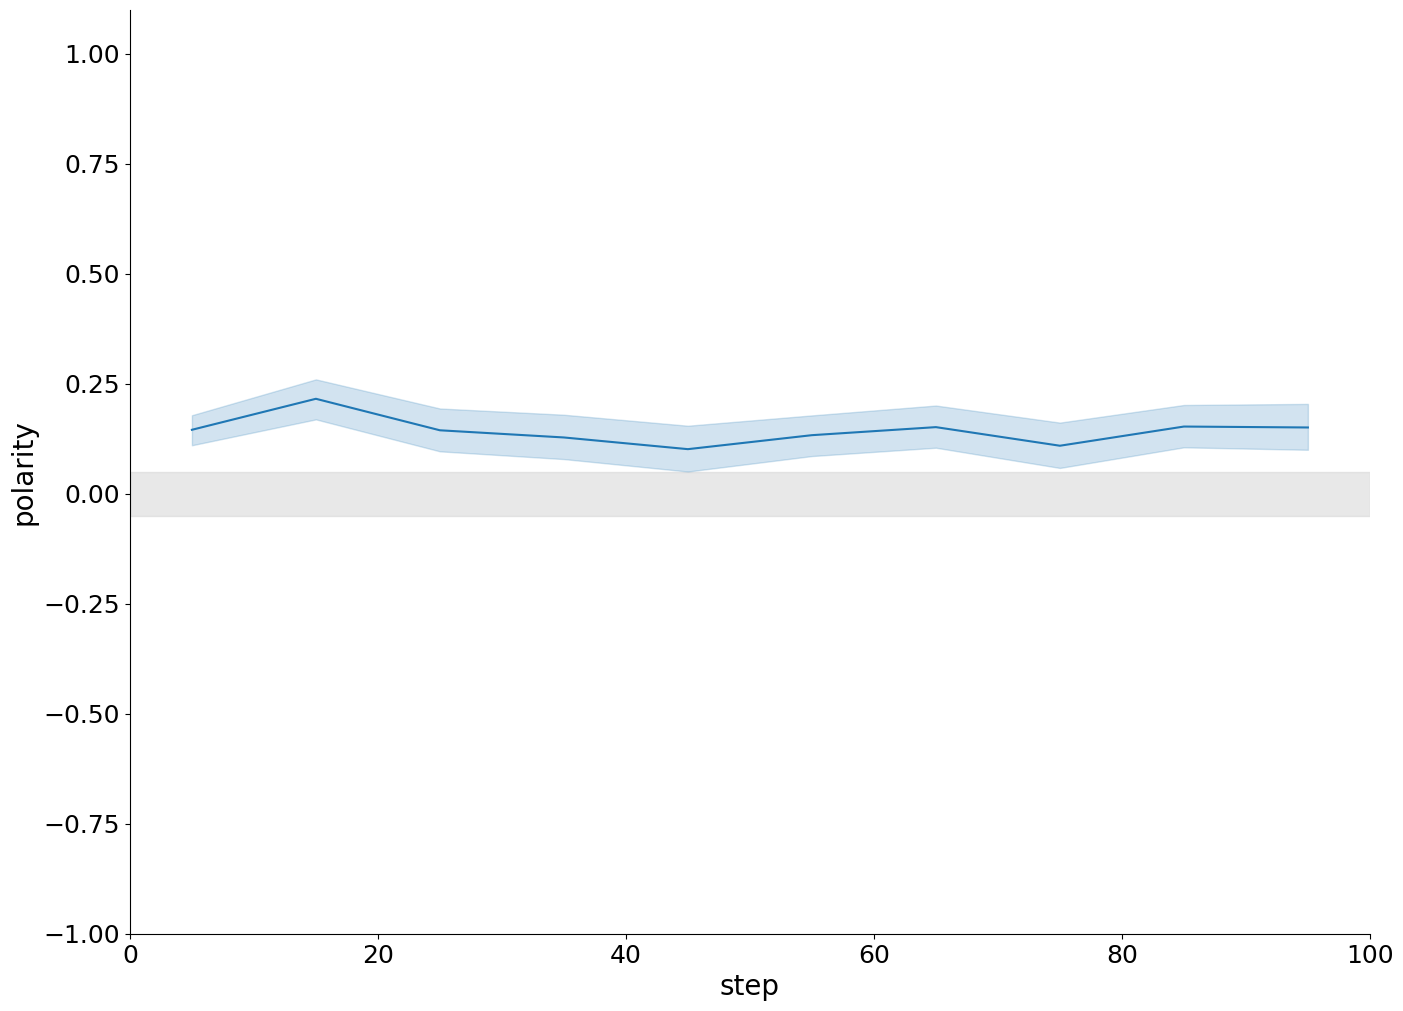

In [10]:
fig = plt.figure(figsize=(16,12))

ax = aggregator.plot(segmented_df)

# adjust font sizes
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(18)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(18)
ax.set_xlabel("step", fontsize=20)
ax.set_ylabel("polarity", fontsize=20);

## 4.1 Use Different Aggregation Strategies

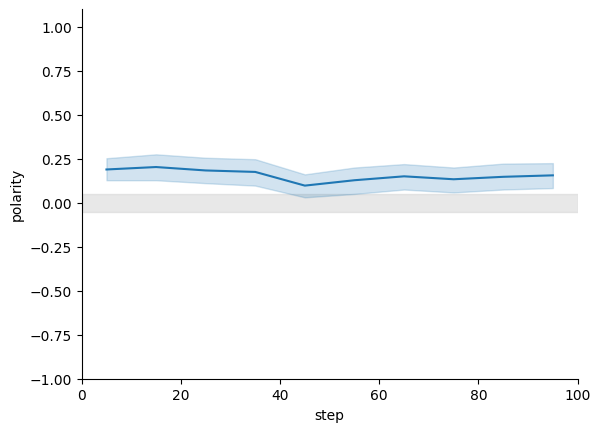

In [11]:
aggregation.PolarityAggregator("last").plot(segmented_df);

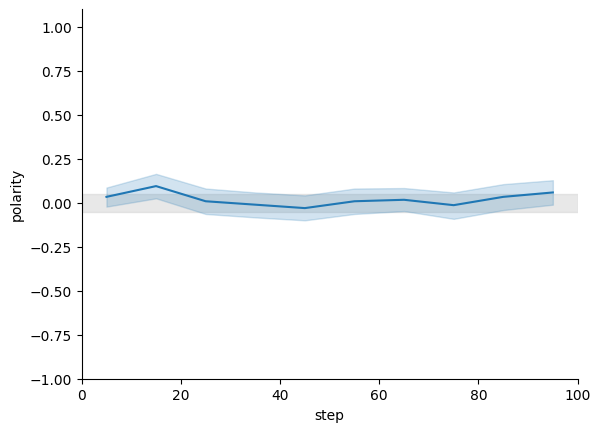

In [9]:
aggregation.PolarityAggregator(aggregation.majority).plot(segmented_df);

## 4.2 Plot Individual Trendlines of Subsample

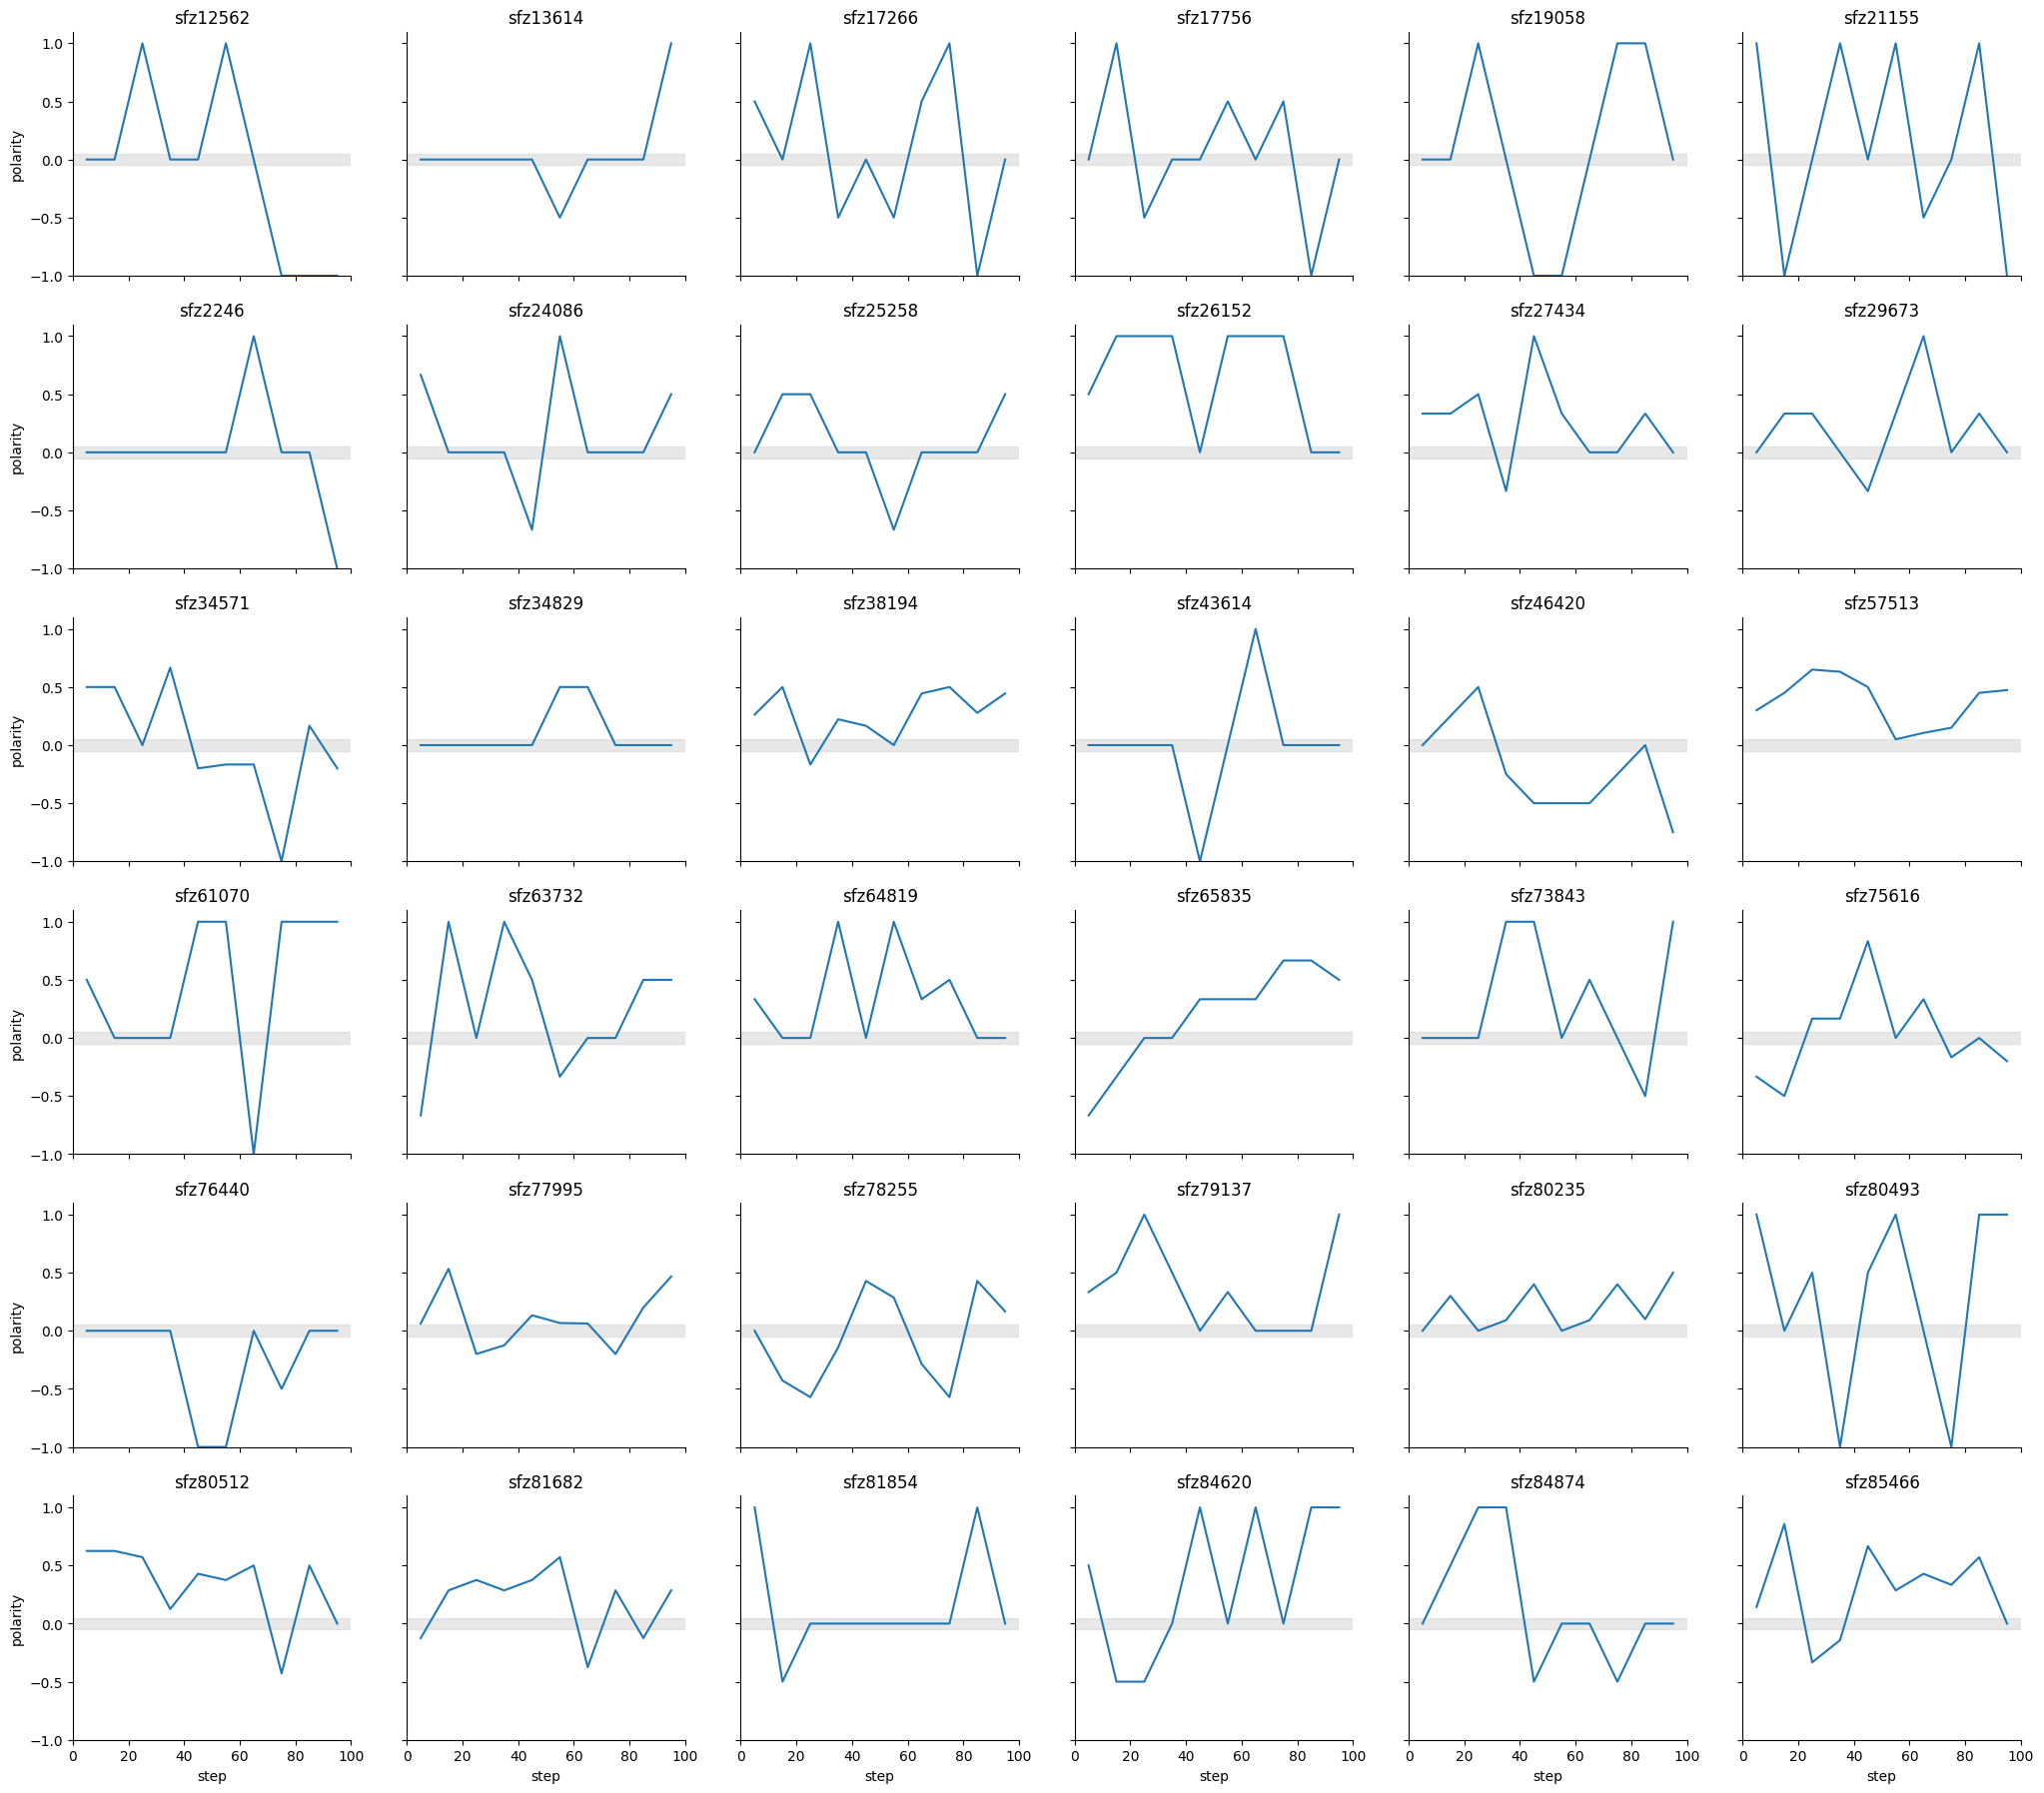

In [13]:
# subsample
ids = [
    "sfz12562", "sfz13614", "sfz17266", "sfz17756", "sfz19058", "sfz21155",
    "sfz2246", "sfz24086", "sfz25258", "sfz26152", "sfz27434", "sfz29673",
    "sfz34571", "sfz34829", "sfz38194", "sfz43614", "sfz46420", "sfz57513",
    "sfz61070", "sfz63732", "sfz64819", "sfz65835", "sfz73843", "sfz75616",
    "sfz76440", "sfz77995", "sfz78255", "sfz79137", "sfz80235", "sfz80493",
    "sfz80512", "sfz81682", "sfz81854", "sfz84620", "sfz84874", "sfz85466"
]

aggregator.plot_multiple(segmented_df, ids, nrows=6, figsize=(20,15));

# 5. Explain Classifications

In [14]:
explainer = explanation.BertExplainer(CLASSIFIER_PATH, DEVICE)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ../models/sentiment/fine-tuned/gbert-base-moravian-sentiment and are newly initialized: ['bert.embeddings.position_ids']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## 5.1 True Example

In [15]:
idx = "sfz34829"
selected_df = aggregator.get_single(segmented_df, idx)
selected_df

,source,n,text,label,polarity,step
9982,sfz34829,0,"Hohenzollern: Joseph Wilhelm, Prinz von H.-Hec...",neutral,0,5
9983,sfz34829,1,1836 zu Oliva bei Danzig.,neutral,0,5
9984,sfz34829,2,Er erhielt seine erste Erziehung in Wien und a...,neutral,0,15
9985,sfz34829,3,"1790 nahm ihn sein Oheim, Karl, Reichsgraf von...",neutral,0,15
9986,sfz34829,4,"1800 wurde er von seinem Oheim, der 1795 Fürst...",neutral,0,25
9987,sfz34829,5,"Am 6. Juli 1808 wurde er, von dem Könige „nomi...",neutral,0,35
9988,sfz34829,6,In Folge der politischen Wirren wurde er erst ...,neutral,0,35
9989,sfz34829,7,Als die katholisch-kirchlichen Verhältnisse in...,neutral,0,45
9990,sfz34829,8,Mit der Diöcese Ermland wurden damals das früh...,neutral,0,55
9991,sfz34829,9,"— H. war ein fein gebildeter Mann, fromm und w...",positive,1,55


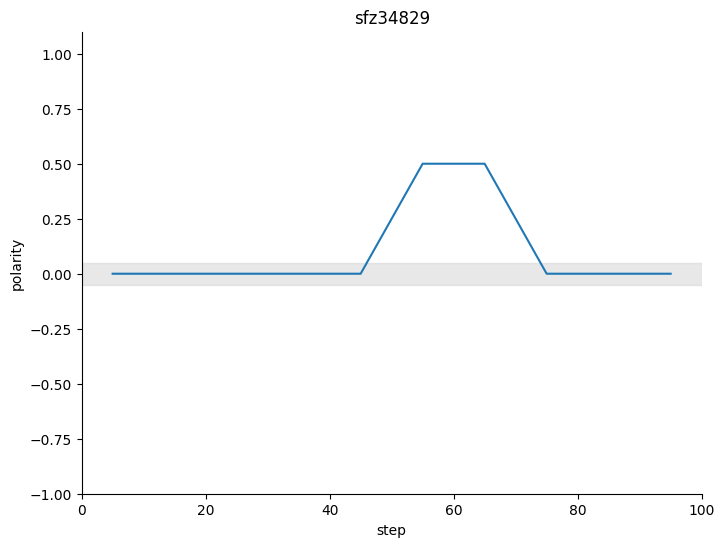

In [16]:
fig = plt.figure(figsize=(8,6))

aggregator.plot(selected_df, idx);

In [17]:
step_df = aggregator.get_steps(selected_df, [55, 65])

display(HTML( explainer.explain_as_html_table(step_df, classification.get_hsl) ))

/home/pb/Dokumente/GitHub/DHd25_WwwwKlassifiziert/.venv/lib/python3.12/site-packages/transformers/modeling_utils.py:1113: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


source,n,text,label,negative,neutral,positive
sfz34829,8,Mit der Diöcese Ermland wurden damals das frühere Bisthum Samland und ein Theil des früheren Bisthums Pomesanien vereinigt.,neutral,0.12%,99.77%,0.11%
sfz34829,9,"— H. war ein fein gebildeter Mann, fromm und wohlthätig und ein gewissenhafter und eifriger Bischof.",positive,0.16%,0.10%,99.74%
sfz34829,10,Namentlich machte er sich in seiner Diöcese um das Schulwesen verdient:,positive,0.54%,1.57%,97.89%
sfz34829,11,"1811 wurde das Gymnasium, 1817 die theologische Lehranstalt zu Braunsberg errichtet, letztere 1821 als Lyceum Hosianum organisirt.",neutral,0.12%,99.80%,0.08%


## 5.2 False Example

In [18]:
idx = "sfz80512"
selected_df = aggregator.get_single(segmented_df, idx)
selected_df

,source,n,text,label,polarity,step
10344,sfz80512,0,"Solger: Karl Wilhelm Ferdinand S., wurde gebor...",neutral,0,5
10345,sfz80512,1,Sein Vater war Director der markgräflichen Kam...,positive,1,5
10346,sfz80512,2,Die Mutter war von hingebender Güte und Sanftmut;,positive,1,5
10347,sfz80512,3,sie ging völlig in der liebevollen Fürsorge fü...,positive,1,5
10348,sfz80512,4,"Mit seinen Geschwistern, einem jüngeren Bruder...",positive,1,5
...,...,...,...,...,...,...
10415,sfz80512,71,„De explicatione ellipsium in lingua graeca“ —...,neutral,0,95
10416,sfz80512,72,"1, Frankfurt a. O. 1811;",neutral,0,95
10417,sfz80512,73,„Erwin. Vier Gespräche über das Schöne und die...,neutral,0,95
10418,sfz80512,74,"„Philosophische Gespräche“,|Berlin 1817;",neutral,0,95


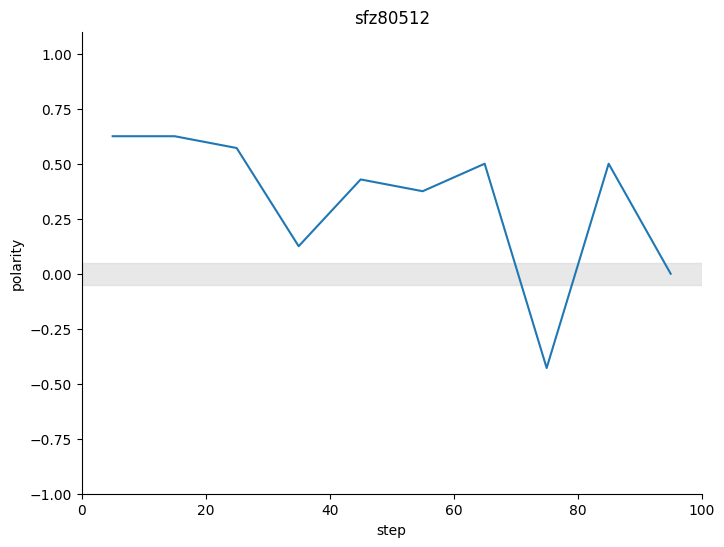

In [19]:
fig = plt.figure(figsize=(8,6))

aggregator.plot(selected_df, idx);

In [20]:
steps = [75]
step_df = aggregator.get_steps(selected_df, steps)

explanation_table = explainer.explain_as_html_table(step_df, classification.get_hsl)
display(HTML( explanation_table ))

/home/pb/Dokumente/GitHub/DHd25_WwwwKlassifiziert/.venv/lib/python3.12/site-packages/transformers/modeling_utils.py:1113: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


In [21]:
with open (f"../data/sentiment/predictions_explained/{idx}_classified_{'-'.join(str(i) for i in steps)}.html", "w") as f:
    f.write(explanation_table)